In [1]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torchvision
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
zip_path = '/content/drive/MyDrive/Deepfake/deepfake.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [4]:
path = "/content/Dataset"
count = sum(len(files) for _, _, files in os.walk(path))
print(f"Total files: {count}")


Total files: 190335


In [14]:
# Configuration
data_dir = '/content/Dataset'
output_dir = '/content/'
num_classes = 2
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Data Transforms
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Datasets and loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Validation', 'Test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='Train'), num_workers=2) for x in ['Train', 'Validation', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation', 'Test']}
class_names = image_datasets['Train'].classes
print(f"Classes: {class_names}")

Classes: ['Fake', 'Real']


In [7]:
model = models.resnet18(pretrained=True)
# Replace Final Layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and Validation Loop
best_model_wts = None
best_acc = 0.0
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for phase in ['Train', 'Validation']:
        if phase == 'Train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase], desc=phase):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'Train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # copy the model
        if phase == 'Validation' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict().copy()

print(f'Best Validation Acc: {best_acc:.4f}')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


Epoch 1/10
----------


Train: 100%|██████████| 4376/4376 [08:40<00:00,  8.41it/s]


Train Loss: 0.1555 Acc: 0.9347


Validation: 100%|██████████| 1233/1233 [01:14<00:00, 16.57it/s]


Validation Loss: 0.0988 Acc: 0.9613
Epoch 2/10
----------


Train: 100%|██████████| 4376/4376 [08:30<00:00,  8.58it/s]


Train Loss: 0.1173 Acc: 0.9524


Validation: 100%|██████████| 1233/1233 [01:14<00:00, 16.50it/s]


Validation Loss: 0.1007 Acc: 0.9602
Epoch 3/10
----------


Train: 100%|██████████| 4376/4376 [08:33<00:00,  8.52it/s]


Train Loss: 0.1044 Acc: 0.9572


Validation: 100%|██████████| 1233/1233 [01:14<00:00, 16.52it/s]


Validation Loss: 0.0955 Acc: 0.9667
Epoch 4/10
----------


Train: 100%|██████████| 4376/4376 [08:30<00:00,  8.57it/s]


Train Loss: 0.0979 Acc: 0.9591


Validation: 100%|██████████| 1233/1233 [01:13<00:00, 16.78it/s]


Validation Loss: 0.0572 Acc: 0.9790
Epoch 5/10
----------


Train: 100%|██████████| 4376/4376 [08:28<00:00,  8.60it/s]


Train Loss: 0.0924 Acc: 0.9618


Validation: 100%|██████████| 1233/1233 [01:15<00:00, 16.32it/s]


Validation Loss: 0.1003 Acc: 0.9655
Epoch 6/10
----------


Train: 100%|██████████| 4376/4376 [08:27<00:00,  8.63it/s]


Train Loss: 0.0894 Acc: 0.9626


Validation: 100%|██████████| 1233/1233 [01:13<00:00, 16.82it/s]


Validation Loss: 0.0623 Acc: 0.9781
Epoch 7/10
----------


Train: 100%|██████████| 4376/4376 [08:27<00:00,  8.62it/s]


Train Loss: 0.0846 Acc: 0.9645


Validation: 100%|██████████| 1233/1233 [01:14<00:00, 16.56it/s]


Validation Loss: 0.0641 Acc: 0.9794
Epoch 8/10
----------


Train: 100%|██████████| 4376/4376 [08:35<00:00,  8.49it/s]


Train Loss: 0.0717 Acc: 0.9699


Validation: 100%|██████████| 1233/1233 [01:16<00:00, 16.09it/s]


Validation Loss: 0.0450 Acc: 0.9847
Epoch 9/10
----------


Train: 100%|██████████| 4376/4376 [08:38<00:00,  8.43it/s]


Train Loss: 0.0655 Acc: 0.9726


Validation: 100%|██████████| 1233/1233 [01:15<00:00, 16.42it/s]


Validation Loss: 0.0405 Acc: 0.9862
Epoch 10/10
----------


Train: 100%|██████████| 4376/4376 [08:32<00:00,  8.54it/s]


Train Loss: 0.0641 Acc: 0.9737


Validation: 100%|██████████| 1233/1233 [01:16<00:00, 16.18it/s]

Validation Loss: 0.0409 Acc: 0.9872
Best Validation Acc: 0.9872


In [8]:
model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['Test'], desc='Test'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
test_acc = running_corrects.double() / dataset_sizes['Test']
print(f'Test Acc: {test_acc:.4f}')

Test: 100%|██████████| 341/341 [00:20<00:00, 17.02it/s]

Test Acc: 0.8327


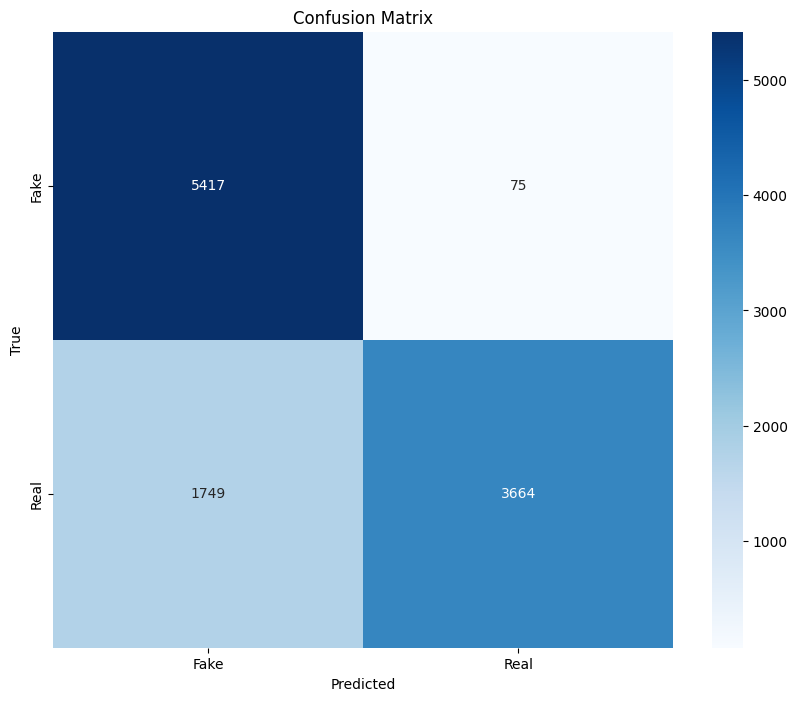

In [9]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

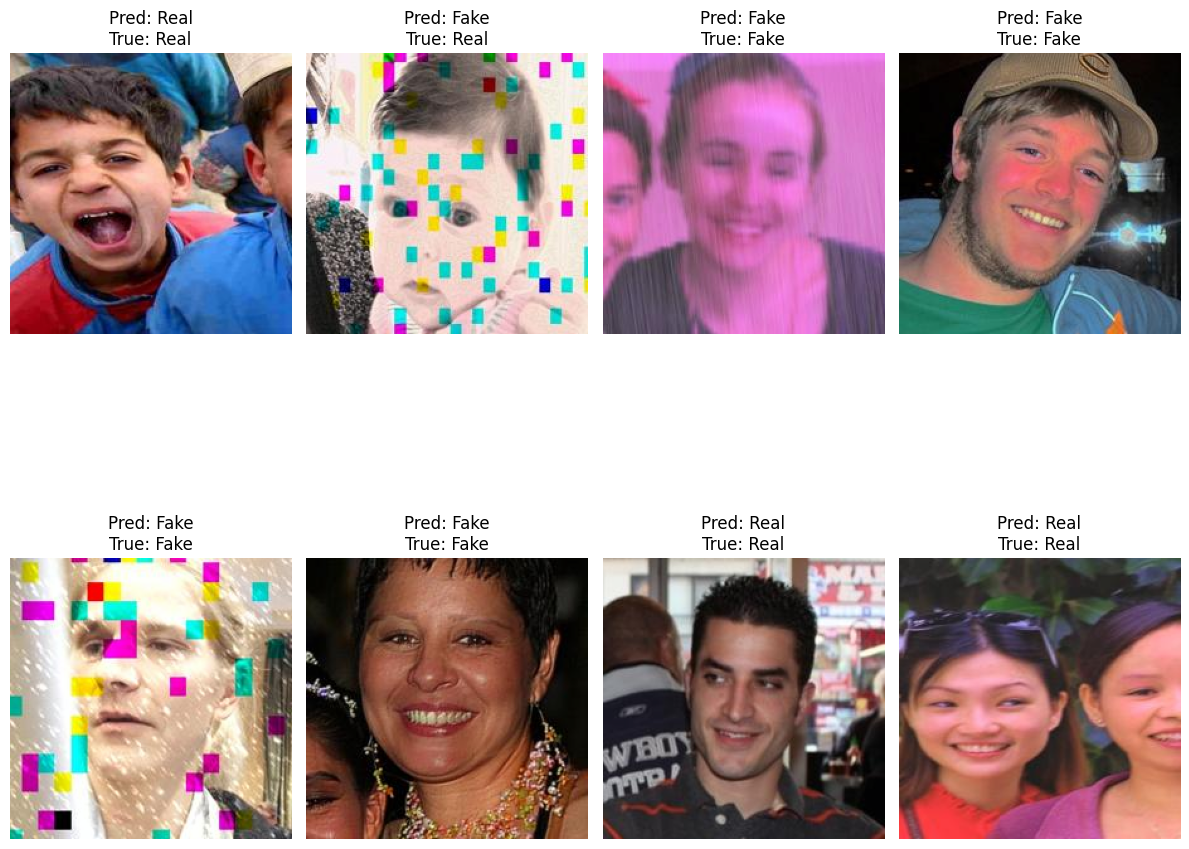

In [19]:
dataloaders['Test'] = torch.utils.data.DataLoader(
    image_datasets['Test'],
    batch_size=32,
    shuffle=False,
    num_workers=0,   # ✅ single-threaded, safe
    pin_memory=False
)

all_test_inputs, all_test_labels = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        # Randomly pick 1-2 samples per batch instead of all
        for i in random.sample(range(len(inputs)), min(2, len(inputs))):
            all_test_inputs.append(inputs[i].cpu())
            all_test_labels.append(labels[i].cpu())

# Randomly pick 8 total
random_indices = random.sample(range(len(all_test_inputs)), 8)
selected_inputs = torch.stack([all_test_inputs[i] for i in random_indices])
selected_labels = torch.tensor([all_test_labels[i] for i in random_indices])

selected_inputs = selected_inputs.to(device)
selected_labels = selected_labels.to(device)
outputs = model(selected_inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 12))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow(selected_inputs.cpu().data[i],
           title=f'Pred: {class_names[preds[i]]}\nTrue: {class_names[selected_labels[i]]}')
plt.tight_layout()
plt.show()


In [15]:
model_path = os.path.join(output_dir, 'deepfake_resnet18.pth')
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to /content/deepfake_resnet18.pth
